In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import json
from shapely.geometry import shape
from adjustText import adjust_text
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm
import mapclassify
from scipy.stats import pearsonr
import statsmodels.api as sm

In [2]:
def split_str_into_lines(input_str: str, line_length: int):
    words = input_str.split(" ")
    line_count = 0
    split_input = ""
    for word in words:
        line_count += 1
        line_count += len(word)
        if line_count > line_length:
            split_input += "\n"
            line_count = len(word) + 1
            split_input += word
            split_input += " "
        else:
            split_input += word
            split_input += " "
    
    return split_input

In [3]:
encuestados_rosario = pd.read_excel("Rosario F.xlsx")
# Eliminamos los datos que están por fuera de nuestro mapa de la ciudad de Rosario
encuestados_rosario = encuestados_rosario[encuestados_rosario.Coord1__Latitude < -32.85]
encuestados_rosario = encuestados_rosario[encuestados_rosario.Coord1__Longitude < -60.5]
encuestados_rosario = encuestados_rosario[encuestados_rosario.Coord1__Longitude > -60.78]

geo_encuestados = gpd.GeoDataFrame(
    encuestados_rosario, geometry=gpd.points_from_xy(encuestados_rosario.Coord1__Longitude,encuestados_rosario.Coord1__Latitude, crs="EPSG:4326")
)

geo_encuestados = geo_encuestados.drop(["interview__key", "Coord1__Latitude", "Coord1__Longitude", "RADIO"], axis='columns')

In [4]:
pd.set_option("display.max_colwidth", None) # Muestra todas las celdas completas
distritos_df = pd.read_csv("data/distritos_descentralizados_json.csv", encoding="cp1252", dtype={"GEOJSON": str})
#print(distritos_df["GEOJSON"])
def convertir_a_geometria(string_geojson):
    # Cargar el string como objeto JSON
    geojson_obj = json.loads(string_geojson)
    # Extraer la geometría y convertirla a objeto Shapely
    return shape(geojson_obj['geometry'])
distritos_df["geometry"] = distritos_df["GEOJSON"].apply(convertir_a_geometria)
distritos_df = distritos_df.drop(columns=["GEOJSON", "OBSERVACIO"])
mapa_distritos = gpd.GeoDataFrame(distritos_df, geometry='geometry')
mapa_distritos = mapa_distritos.set_crs("EPSG:4326", 4326)

print(mapa_distritos.columns)

Index(['DISTRITO', 'geometry'], dtype='object')


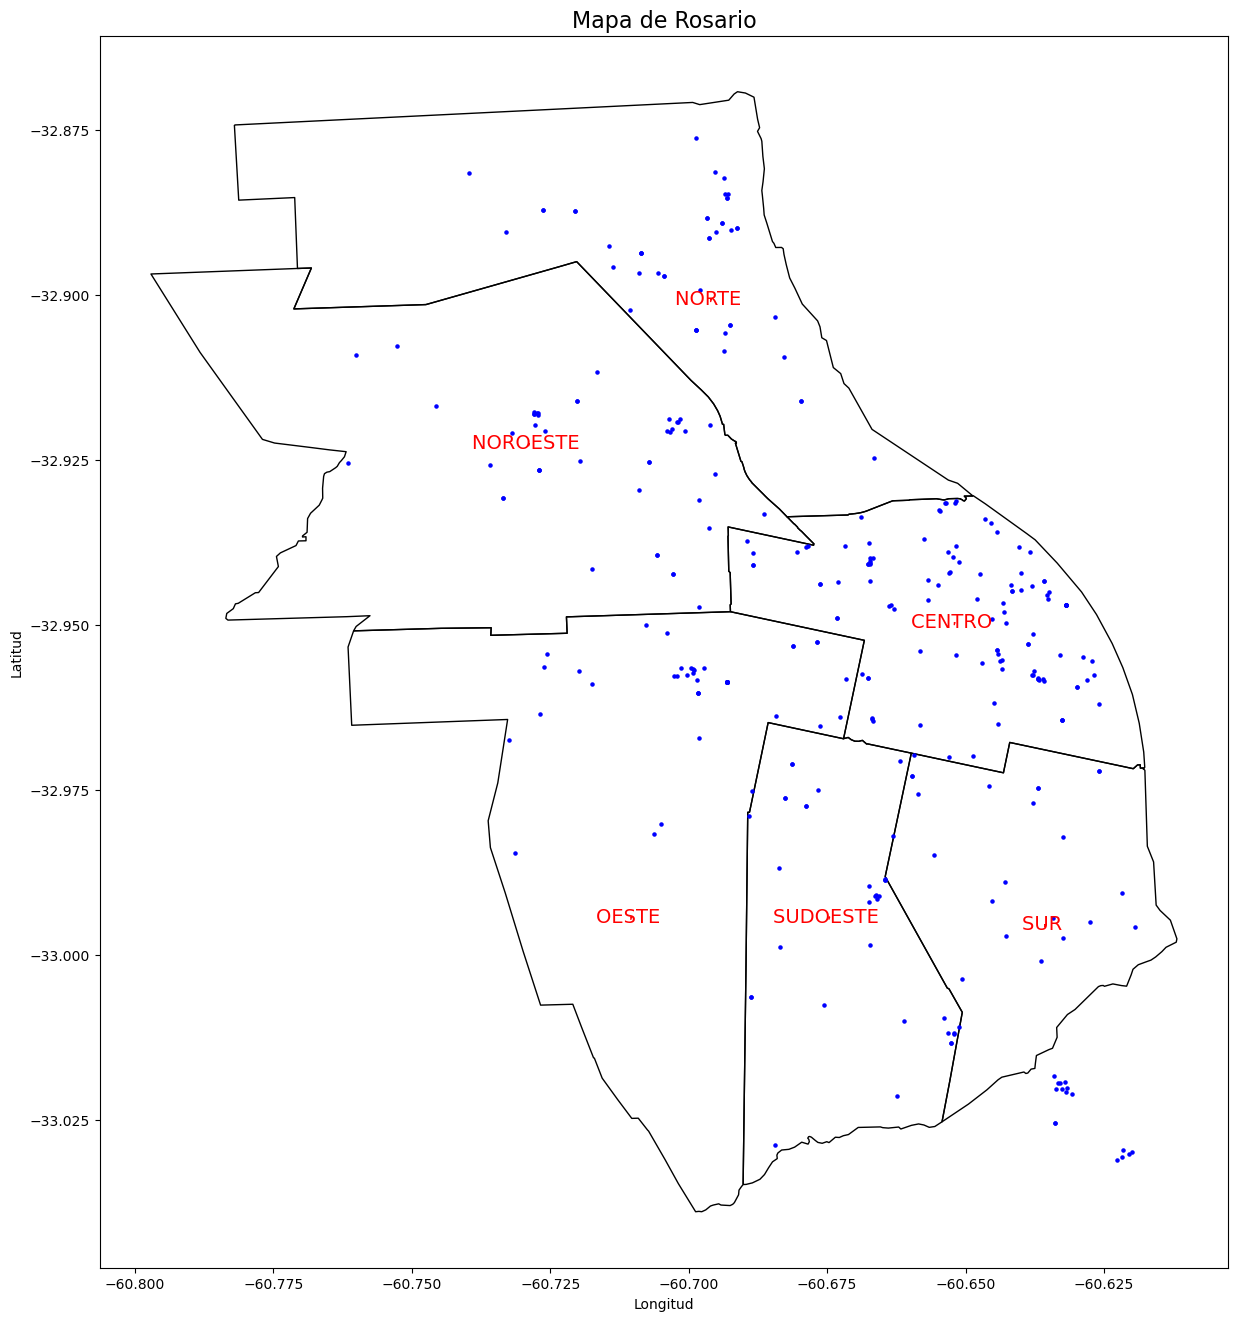

In [5]:
# Mapa con los nombres de los distritos y los lugares donde se encuestó

fig, ax = plt.subplots(figsize=(16,16))
mapa_distritos.plot(ax=ax, color="None", edgecolor="black")
etiquetas = []
for geometria, distrito in zip(mapa_distritos.geometry, mapa_distritos['DISTRITO']):
    geometria_x, geometria_y = geometria.centroid.x, geometria.centroid.y
    area = geometria.area
    geometria_x, geometria_y = geometria.representative_point().x, geometria.representative_point().y
    distrito = split_str_into_lines(distrito, 13)
    
    if area * 10000 > 2:
        etiquetas.append(ax.text(geometria_x, geometria_y, distrito, fontsize=14, ha='center', color='red'))
    elif area * 10000 > 1:
        etiquetas.append(ax.text(geometria_x, geometria_y, distrito, fontsize=12, ha='center', color='red'))
    else:
        etiquetas.append(ax.text(geometria_x, geometria_y, distrito, fontsize=7, ha='center', color='red'))
adjust_text(etiquetas, ax=ax, avoid_self=False, arrowprops=dict(arrowstyle='->', color='red'))
ax.set_title("Mapa de Rosario", fontsize=16)
ax.set_xlabel("Longitud")
ax.set_ylabel("Latitud")

geo_encuestados.plot(ax=ax, marker="o", markersize=5, color="blue")
plt.show()

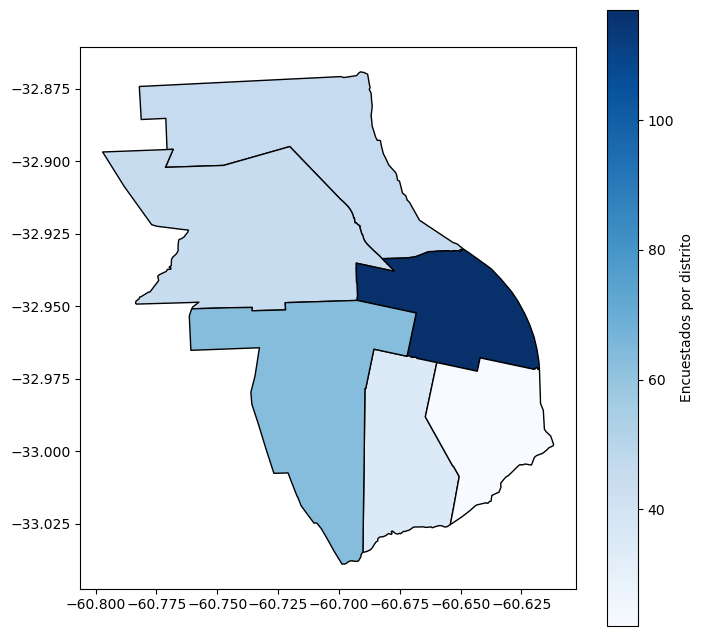

In [6]:
mapa_distritos["N_encuestados"] = 0
for fila, distrito in mapa_distritos.iterrows():
    n = geo_encuestados[geo_encuestados.geometry.within(distrito.geometry)].shape[0]
    mapa_distritos.at[fila, "N_encuestados"] = n

fig, ax = plt.subplots(figsize=(8,8))
mapa_distritos.plot(
    ax = ax,
    edgecolor = "black",
    column = "N_encuestados",
    legend = True,
    legend_kwds = {"label": "Encuestados por distrito", "orientation": "vertical"},
    cmap = "Blues"
)

plt.show()

In [7]:
# Fusionamos los individuos encuestados con los datos del distrito


mapa_distritos["individuos"] = mapa_distritos.apply(
    lambda row: geo_encuestados[geo_encuestados.geometry.within(row.geometry)], axis=1
)

# Crear una función para contar los valores de la columna 'columna_interes' en los individuos de cada distrito
def contar_valores(sub_gdf, columna_interes):
    if sub_gdf.empty:
        return {}
    # Contar ocurrencias de cada valor en la columna
    return sub_gdf[columna_interes].value_counts().to_dict()

# Aplicar la función a cada fila del GeoDataFrame de distritos
mapa_distritos['conteo_valores'] = mapa_distritos['individuos'].apply(
    lambda sub_gdf: contar_valores(sub_gdf, 'INT DE VOTO X ESPACIO')
)
# Expandir los conteos en columnas separadas
conteos_expandido = mapa_distritos['conteo_valores'].apply(pd.Series).fillna(0)
# Agregar estas columnas al GeoDataFrame de distritos
mapa_distritos = pd.concat([mapa_distritos, conteos_expandido], axis=1)

mapa_distritos = mapa_distritos.loc[:,~mapa_distritos.columns.duplicated()]

print(mapa_distritos.columns)

Index(['DISTRITO', 'geometry', 'N_encuestados', 'individuos', 'conteo_valores',
       'JxC', 'FdT', 'LIBERTARIOS', 'NINGUNO/NOSABE', 'OTROS', 'PNK', 'FIT'],
      dtype='object')


In [8]:
mapa_distritos["NINGUNO/NOSABE_PCT"] = (mapa_distritos["NINGUNO/NOSABE"] * 100) / mapa_distritos["N_encuestados"]
mapa_distritos["OTROS_PCT"] = (mapa_distritos["OTROS"] * 100) / mapa_distritos["N_encuestados"]
mapa_distritos["LIBERTARIOS_PCT"] = (mapa_distritos["LIBERTARIOS"] * 100) / mapa_distritos["N_encuestados"]
mapa_distritos["FIT_PCT"] = (mapa_distritos["FIT"] * 100) / mapa_distritos["N_encuestados"]
mapa_distritos["PNK_PCT"] = (mapa_distritos["PNK"] * 100) / mapa_distritos["N_encuestados"]
mapa_distritos["JxC_PCT"] = (mapa_distritos["JxC"] * 100) / mapa_distritos["N_encuestados"]
mapa_distritos["FdT_PCT"] = (mapa_distritos["FdT"] * 100) / mapa_distritos["N_encuestados"]

norm = Normalize(vmin=0, vmax=100)

In [58]:
def dibujar_intencion_voto_por_area(columna, cmap, label, titulo, gdf=mapa_distritos, bins=None, export=False, show=True):

    if bins is not None:
        # Crear una clasificación manual basada en los bins
        norm = BoundaryNorm(bins, ncolors=plt.get_cmap(cmap).N, clip=True)
    else:
        # Clasificación automática (cuantiles en este caso)
        bins = [0, 10]
        classifier = mapclassify.Quantiles(gdf[columna], k=4)  # 5 clases por defecto
        bins = np.append(bins, classifier.bins)
        #print(bins)
        norm = BoundaryNorm(bins, ncolors=plt.get_cmap(cmap).N, clip=True)

    fig, ax = plt.subplots(figsize=(8,8))
    gdf.plot(
        ax = ax,
        edgecolor = "black",
        column = columna,
        legend = True,
        legend_kwds = {"label": label, "orientation": "vertical", "fmt": ":.0f"},
        cmap = cmap,
        norm = norm
    )
    ax.set_title(f"Rosario ({titulo})", fontsize=16)
    if export == True: 
        plt.savefig(titulo)
    if show == True:
        plt.show()

#Votos NINGUNO/NOSABE
dibujar_intencion_voto_por_area("NINGUNO/NOSABE_PCT", "Greys", "Votos en blanco o indecisos por distrito (en porcentaje)",
                                "votos indecisos o en blanco")
# Votos a otros
dibujar_intencion_voto_por_area("OTROS_PCT", "Greys", "Votos a otros por distrito (en porcentaje)",
                                "votos a partidos minoritarios", bins=[0, 5, 10, 15, 20])
# Votos al FIT
dibujar_intencion_voto_por_area("FIT_PCT", "Reds", "Votos al FIT por distrito (en porcentaje)",
                                "votos al FIT", bins=[0, 3, 6, 10, 15, 20])
# Votos a JxC
dibujar_intencion_voto_por_area("JxC_PCT", "Wistia", "Votos a JxC por distrito (en porcentaje)",
                                "votos a JxC")
# Votos al FdT
dibujar_intencion_voto_por_area("FdT_PCT", "Blues", "Votos al FdT por distrito (en porcentaje)",
                                "votos al FdT", bins=[0, 10, 20.82, 23.09, 25, 27, 30])
# Votos a libertarios
dibujar_intencion_voto_por_area("LIBERTARIOS_PCT", "Purples", "Votos a libertarios por distrito (en porcentaje)",
                                "votos a libertarios", bins=[0, 10, 13.8, 15.3, 16.7, 18, 20, 25])
# Votos a Peronismo no Kirchnerista
dibujar_intencion_voto_por_area("PNK_PCT", "Greens", "Votos a otros peronismo no K por distrito (en porcentaje)",
                                "votos a peronismo no K", bins=[0, 5, 10, 15, 20])

SyntaxError: keyword argument repeated: column (3948501692.py, line 19)

In [10]:
def crear_columna_por_partido(nueva_columna, partido_X):
    geo_encuestados[nueva_columna] = geo_encuestados["INT DE VOTO X ESPACIO"] == partido_X
    geo_encuestados[nueva_columna] = geo_encuestados[nueva_columna].astype(int)

crear_columna_por_partido("Voto_Libertarios", "LIBERTARIOS")
crear_columna_por_partido("Voto_JxC", "JxC")
crear_columna_por_partido("Voto_FdT", "FdT")
crear_columna_por_partido("Voto_FIT", "FIT")
crear_columna_por_partido("Voto_NINGUNO/NOSABE", "NINGUNO/NOSABE")
crear_columna_por_partido("Voto_OTROS", "OTROS")
crear_columna_por_partido("Voto_PNK", "PNK")

#print(geo_encuestados['Voto_Libertarios'].unique())
#print(geo_encuestados["Voto_JxC"].unique())
#print(geo_encuestados["Voto_FdT"].unique())
#print(geo_encuestados["Voto_FIT"].unique())
#print(geo_encuestados["Voto_NINGUNO/NOSABE"].unique())
#print(geo_encuestados["Voto_OTROS"].unique())
#print(geo_encuestados["Voto_PNK"].unique())

#print(geo_encuestados['INT DE VOTO X ESPACIO'].value_counts(dropna=False))
#print(geo_encuestados[geo_encuestados['Voto_Libertarios'].isnull()])

#print(edad_ordenada)
#print(geo_encuestados["EDAD"].unique())

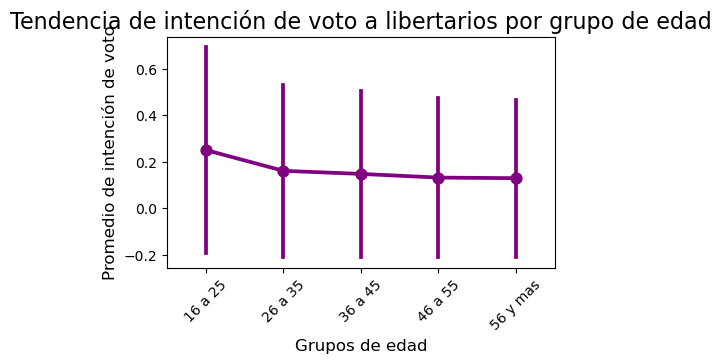

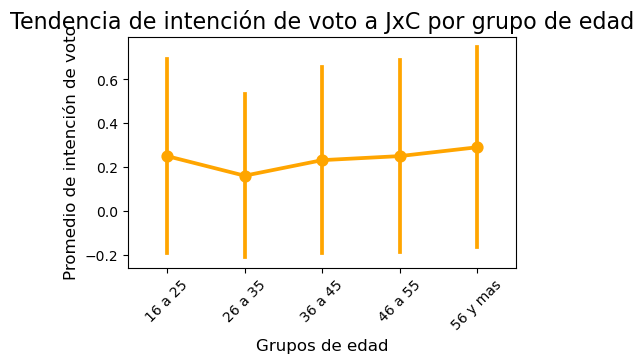

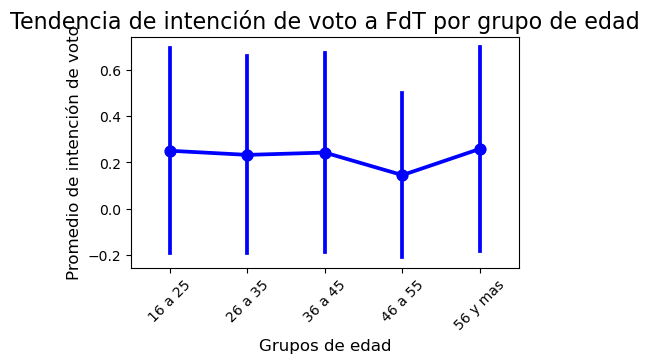

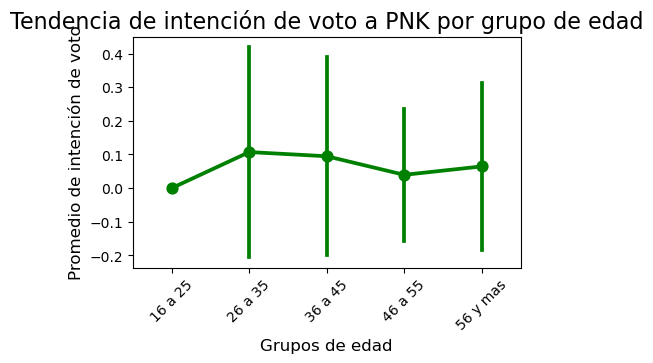

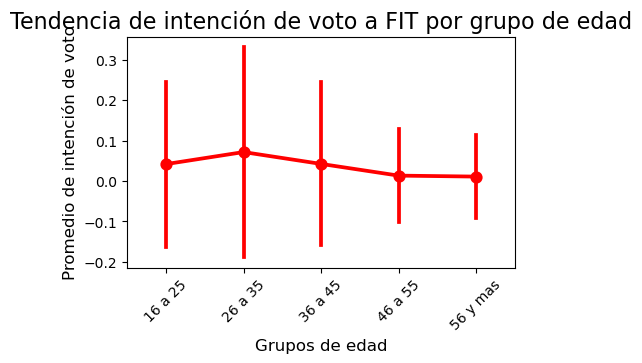

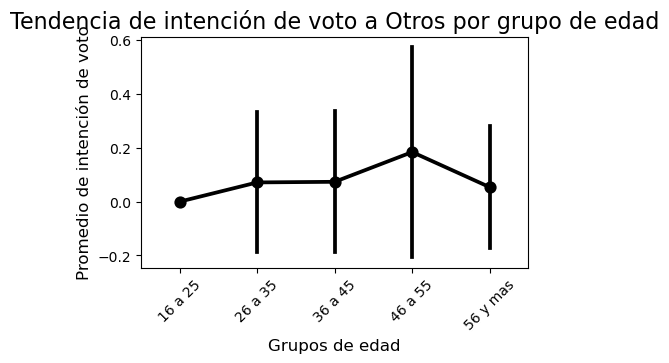

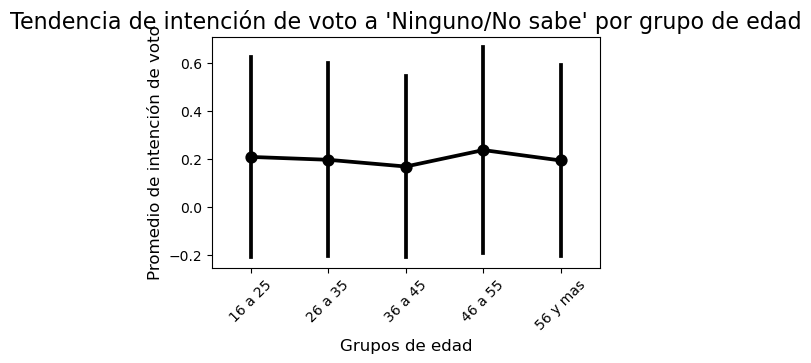

In [11]:
#Ordenar columna de edad en una variable
#edad_ordenada = sorted(geo_encuestados['EDAD'].unique())
#geo_encuestados['Voto_Libertarios'] = geo_encuestados['Voto_Libertarios'].fillna(0).astype(int)
orden_edad = ['16 a 25', '26 a 35', '36 a 45', '46 a 55', '56 y mas']

def dibujar_voto_por_variable(voto_partido_x, color, orden, titulo, eje_x="EDAD", data=geo_encuestados):
    plt.figure(figsize=(5, 3))
    sns.pointplot(
        data=geo_encuestados, 
        x=eje_x, 
        y=voto_partido_x, 
        errorbar="sd", 
        markers="o", 
        color=color,
        order = orden_edad
    )
    # Ajustar títulos
    plt.title(f"Tendencia de intención de voto a {titulo} por grupo de edad", fontsize=16)
    plt.xlabel("Grupos de edad", fontsize=12)
    plt.ylabel("Promedio de intención de voto", fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

dibujar_voto_por_variable("Voto_Libertarios", "purple", orden_edad, "libertarios")
dibujar_voto_por_variable("Voto_JxC", "orange", orden_edad, "JxC")
dibujar_voto_por_variable("Voto_FdT", "blue", orden_edad, "FdT")
dibujar_voto_por_variable("Voto_PNK", "green", orden_edad, "PNK")
dibujar_voto_por_variable("Voto_FIT", "red", orden_edad, "FIT")
dibujar_voto_por_variable("Voto_OTROS", "black", orden_edad, "Otros")
dibujar_voto_por_variable("Voto_NINGUNO/NOSABE", "black", orden_edad, "'Ninguno/No sabe'")

In [12]:
def regresion_edad_voto(partido_x, color):
    X = pd.get_dummies(geo_encuestados['EDAD'], drop_first=True)
    X = sm.add_constant(X)
    y = geo_encuestados[partido_x]
    modelo = sm.Logit(y, X.astype(float)).fit()

    predicciones = modelo.predict(X.astype(float))
    resultados = pd.DataFrame({
        "EDAD": geo_encuestados["EDAD"],
        "PROBABILIDAD": predicciones
    })
    # Calcular promedios por categoría de edad
    resultados_promedio = resultados.groupby('EDAD')['PROBABILIDAD'].mean().reset_index()

    # Mostrar modelo de regresión logística
    print(modelo.summary())

    # Mostrar gráfico
    plt.figure(figsize=(5, 3))
    sns.barplot(
        x='EDAD',
        y='PROBABILIDAD',
        data=resultados_promedio,
        #hue=["5","4","3","2","1"],
        #hue=[5,4,3,2,1.7],
        hue=resultados_promedio["PROBABILIDAD"],
        palette = color,
        legend=False,
        order=orden_edad
    )
    # Ajustar títulos y etiquetas
    plt.title(f"Probabilidad de {partido_x} por Grupo de Edad", fontsize=16)
    plt.xlabel("Grupo de Edad", fontsize=12)
    plt.ylabel("Probabilidad Predicha", fontsize=12)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)  # Escala de probabilidad
    plt.show()

Optimization terminated successfully.
         Current function value: 0.416454
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:       Voto_Libertarios   No. Observations:                  344
Model:                          Logit   Df Residuals:                      339
Method:                           MLE   Df Model:                            4
Date:                Tue, 26 Nov 2024   Pseudo R-squ.:                0.007668
Time:                        17:11:14   Log-Likelihood:                -143.26
converged:                       True   LL-Null:                       -144.37
Covariance Type:            nonrobust   LLR p-value:                    0.6965
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0986      0.471     -2.331      0.020      -2.023      -0.175
26 a 35       -0.5543      0.

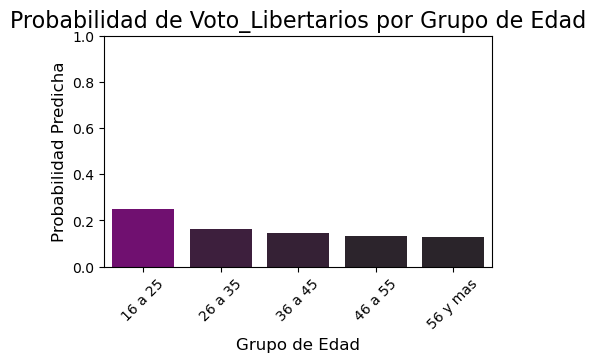

Optimization terminated successfully.
         Current function value: 0.547558
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Voto_JxC   No. Observations:                  344
Model:                          Logit   Df Residuals:                      339
Method:                           MLE   Df Model:                            4
Date:                Tue, 26 Nov 2024   Pseudo R-squ.:                0.009034
Time:                        17:11:14   Log-Likelihood:                -188.36
converged:                       True   LL-Null:                       -190.08
Covariance Type:            nonrobust   LLR p-value:                    0.4880
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0986      0.471     -2.331      0.020      -2.023      -0.175
26 a 35       -0.5543      0.

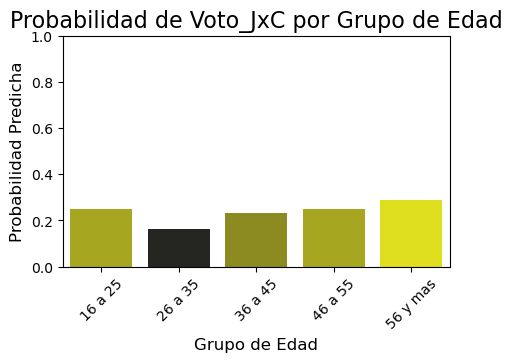

Optimization terminated successfully.
         Current function value: 0.526019
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Voto_FdT   No. Observations:                  344
Model:                          Logit   Df Residuals:                      339
Method:                           MLE   Df Model:                            4
Date:                Tue, 26 Nov 2024   Pseudo R-squ.:                 0.01072
Time:                        17:11:14   Log-Likelihood:                -180.95
converged:                       True   LL-Null:                       -182.91
Covariance Type:            nonrobust   LLR p-value:                    0.4165
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0986      0.471     -2.331      0.020      -2.023      -0.175
26 a 35       -0.0976      0.

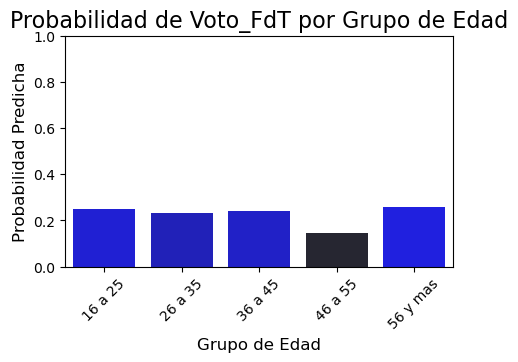

Optimization terminated successfully.
         Current function value: 0.133730
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:               Voto_FIT   No. Observations:                  344
Model:                          Logit   Df Residuals:                      339
Method:                           MLE   Df Model:                            4
Date:                Tue, 26 Nov 2024   Pseudo R-squ.:                 0.05523
Time:                        17:11:15   Log-Likelihood:                -46.003
converged:                       True   LL-Null:                       -48.692
Covariance Type:            nonrobust   LLR p-value:                    0.2506
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.1355      1.022     -3.069      0.002      -5.138      -1.133
26 a 35        0.5705      1.

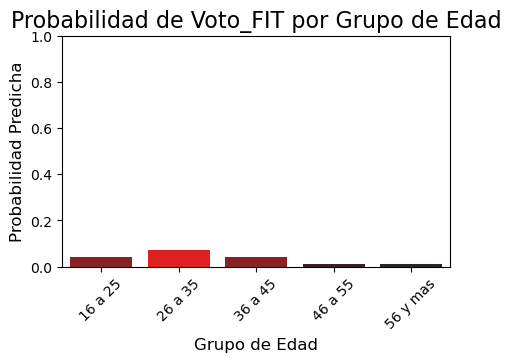

         Current function value: 0.243375
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Voto_PNK   No. Observations:                  344
Model:                          Logit   Df Residuals:                      339
Method:                           MLE   Df Model:                            4
Date:                Tue, 26 Nov 2024   Pseudo R-squ.:                 0.03818
Time:                        17:11:15   Log-Likelihood:                -83.721
converged:                      False   LL-Null:                       -87.045
Covariance Type:            nonrobust   LLR p-value:                    0.1557
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.8050   6.08e+05   -4.9e-05      1.000   -1.19e+06    1.19e+06
26 a 35       27.6847   6.08e+05   4.55e-05      1.000   -1.19e+0

F:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


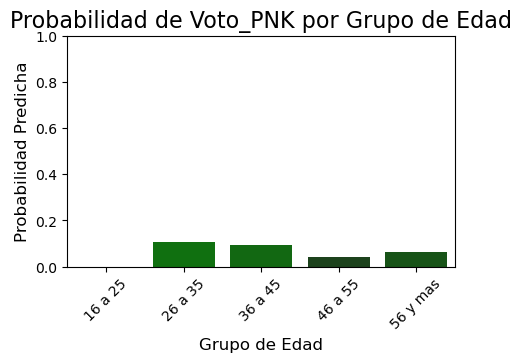

         Current function value: 0.276705
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:             Voto_OTROS   No. Observations:                  344
Model:                          Logit   Df Residuals:                      339
Method:                           MLE   Df Model:                            4
Date:                Tue, 26 Nov 2024   Pseudo R-squ.:                 0.06529
Time:                        17:11:15   Log-Likelihood:                -95.187
converged:                      False   LL-Null:                       -101.84
Covariance Type:            nonrobust   LLR p-value:                  0.009910
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.8049   6.14e+05  -4.85e-05      1.000    -1.2e+06     1.2e+06
26 a 35       27.2400   6.14e+05   4.44e-05      1.000    -1.2e+0

F:\Anaconda\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


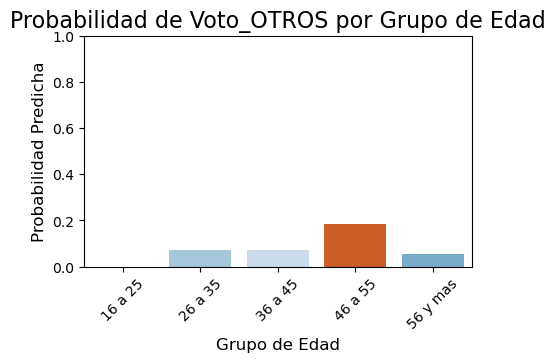

Optimization terminated successfully.
         Current function value: 0.495326
         Iterations 5
                            Logit Regression Results                           
Dep. Variable:     Voto_NINGUNO/NOSABE   No. Observations:                  344
Model:                           Logit   Df Residuals:                      339
Method:                            MLE   Df Model:                            4
Date:                 Tue, 26 Nov 2024   Pseudo R-squ.:                0.003692
Time:                         17:11:15   Log-Likelihood:                -170.39
converged:                        True   LL-Null:                       -171.02
Covariance Type:             nonrobust   LLR p-value:                    0.8676
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3350      0.503     -2.656      0.008      -2.320      -0.350
26 a 35       -0.0738

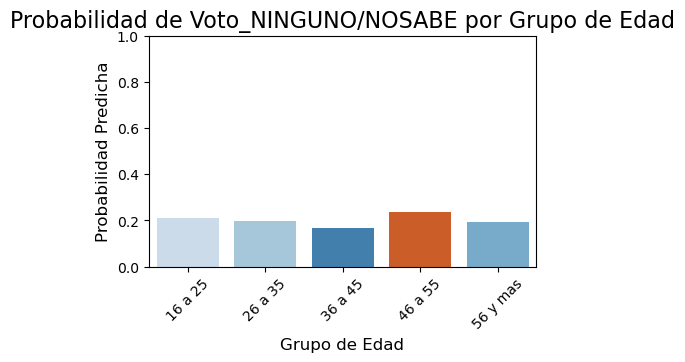

In [13]:
regresion_edad_voto("Voto_Libertarios", "dark:purple")
regresion_edad_voto("Voto_JxC", "dark:yellow")
regresion_edad_voto("Voto_FdT", "dark:blue")
regresion_edad_voto("Voto_FIT", "dark:red")
regresion_edad_voto("Voto_PNK", "dark:green")
regresion_edad_voto("Voto_OTROS", "tab20c")
regresion_edad_voto("Voto_NINGUNO/NOSABE", "tab20c")

In [14]:
pobreza_cronica_sin_geo = pd.read_excel("Nuevos datos/Pobreza Cronica x Radio Censal - Rosario.xlsx")
#print(pobreza_cronica.columns)
pobreza_cronica_sin_geo["geometria"] = pobreza_cronica_sin_geo["Geometría en GeoJSON"].apply(lambda x: shape(json.loads(x)))
pobreza_cronica = gpd.GeoDataFrame(pobreza_cronica_sin_geo, geometry="geometria", crs="EPSG:4326")
pobreza_cronica = pobreza_cronica.drop(["Geometría en GeoJSON", "Código de radio censal", "Código de departamento", "Código de provincia",
                                        "Nombre de provincia", "Código de departamentos/comuna", "Código de radio"], axis=1)

pobreza_cronica.columns.values[3:8] = ["HOG_POB_CR", "PERSONAS_POB_CR", "%HOG_POB_CR", "%PERSONAS_POB_CR", "NIV_INCIDENCIA_POB_CR"]


print(pobreza_cronica[["Hogares", "Población", "HOG_POB_CR", "PERSONAS_POB_CR", "%HOG_POB_CR", "%PERSONAS_POB_CR", "NIV_INCIDENCIA_POB_CR"]])
#print(type(pobreza_cronica))
#pobreza_cronica.plot()

      Hogares  Población  HOG_POB_CR  PERSONAS_POB_CR  %HOG_POB_CR  \
0         186        635          21              130           11   
1          14         46           0                0            0   
2         324       1233          37              221           11   
3         368       1269          29              202            7   
4         435       1480          22              126            5   
...       ...        ...         ...              ...          ...   
1309        4          9           0                0            0   
1310       31        124           9               64           29   
1311      313        868           8               52            2   
1312      336       1034          16              114            4   
1313       27         80           1                8            3   

      %PERSONAS_POB_CR  NIV_INCIDENCIA_POB_CR  
0                   20                      5  
1                    0                      1  
2              

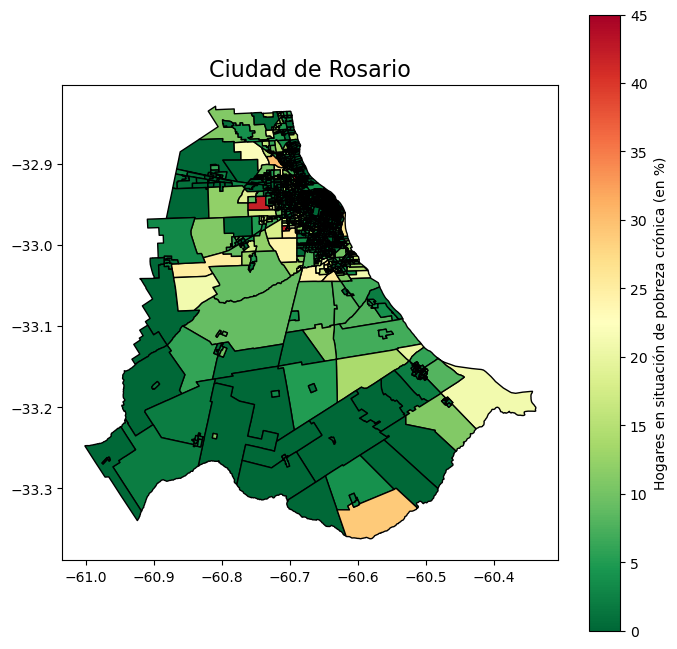

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
pobreza_cronica.plot(
        ax = ax,
        edgecolor = "black",
        column = "%HOG_POB_CR",
        legend = True,
        legend_kwds = {"label": "Hogares en situación de pobreza crónica (en %)", "orientation": "vertical", "fmt": ":.0f"},
        cmap = "RdYlGn_r"
    )
ax.set_title("Ciudad de Rosario", fontsize=16)

plt.show()

In [31]:
hogares_rosario_no_geo = pd.read_excel("Nuevos datos/Estratificación Radios Censales - Rosario Ciudad.xlsx")
hogares_rosario_no_geo["geometria"] = hogares_rosario_no_geo["Geometría en GeoJSON"].apply(lambda x: shape(json.loads(x)))
hogares_rosario = gpd.GeoDataFrame(hogares_rosario_no_geo, geometry="geometria", crs="EPSG:4326")
hogares_rosario = hogares_rosario.drop(["Geometría en GeoJSON", 'Código de radio', 'Nombre de departamentos/comuna', 'Código de radio.1'], axis=1)

#print(hogares_rosario.columns)
#print(hogares_rosario.shape)
hogares_rosario = hogares_rosario.rename(columns={"Segmento socioeconómico del radio": "Segmento_socioeconomico_del_radio"})
print(hogares_rosario["Segmento_socioeconomico_del_radio"])
# Segmento socioeconómico del radio:
    # 1: Clase alta
    # 2: Clase media alta
    # 3: Clase media
    # 4: Clase media baja
    # 5: Clase baja integrada
    # 6: Clase baja
    # 7: Clase muy baja

0       5
1       2
2       7
3       7
4       4
       ..
1061    7
1062    7
1063    7
1064    7
1065    7
Name: Segmento_socioeconomico_del_radio, Length: 1066, dtype: int64


In [33]:
pd.set_option("display.max_columns", None)
rosario_hogares_distritos = gpd.sjoin(hogares_rosario, mapa_distritos, how="inner", predicate="within")
#display(rosario_hogares_distritos.drop(["individuos", "geometria", 'conteo_valores', 'JxC', 'FdT', 'LIBERTARIOS',
                                        #'NINGUNO/NOSABE', 'OTROS', 'PNK', 'FIT'], axis=1))

# Agrupar y sumar los datos por distrito
datos_por_distrito = rosario_hogares_distritos.groupby("DISTRITO")["Segmento_socioeconomico_del_radio"].mean().reset_index()
# Unir los datos agregados a mapa_distritos
mapa_distritos = mapa_distritos.merge(datos_por_distrito, on="DISTRITO", how="left")

print(mapa_distritos[["DISTRITO", "Segmento_socioeconomico_del_radio"]])

   DISTRITO  Segmento_socioeconomico_del_radio
0     NORTE                           3.513043
1  NOROESTE                           4.264463
2    CENTRO                           2.100529
3  SUDOESTE                           4.538462
4     OESTE                           5.443038
5       SUR                           3.693431


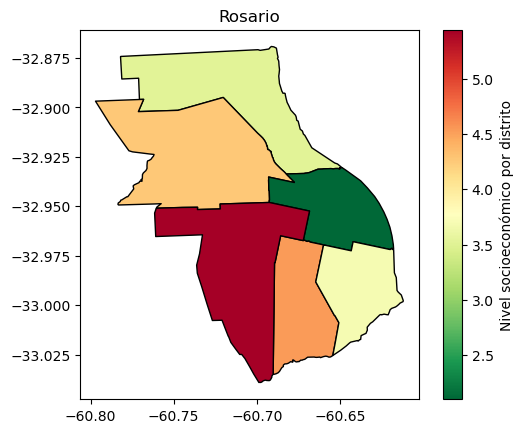

In [43]:
mapa_distritos.plot(
    column="Segmento_socioeconomico_del_radio",
    cmap="RdYlGn_r",
    legend=True,
    legend_kwds = {"label": "Nivel socioeconómico promedio por distrito", "orientation": "vertical", "fmt": ":.0f"},
    edgecolor="black"
)
plt.title("Rosario")
plt.show()

                            OLS Regression Results                            
Dep. Variable:                FdT_PCT   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     3.932
Date:                Tue, 26 Nov 2024   Prob (F-statistic):              0.118
Time:                        17:38:42   Log-Likelihood:                -12.539
No. Observations:                   6   AIC:                             29.08
Df Residuals:                       4   BIC:                             28.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

F:\Anaconda\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


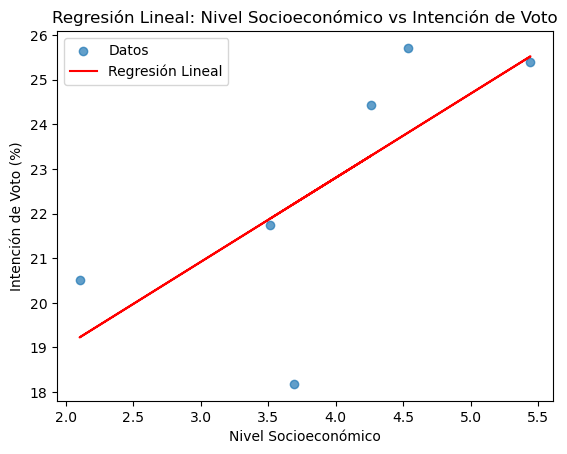

F:\Anaconda\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:                JxC_PCT   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.9470
Date:                Tue, 26 Nov 2024   Prob (F-statistic):              0.386
Time:                        17:38:42   Log-Likelihood:                -18.119
No. Observations:                   6   AIC:                             40.24
Df Residuals:                       4   BIC:                             39.82
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

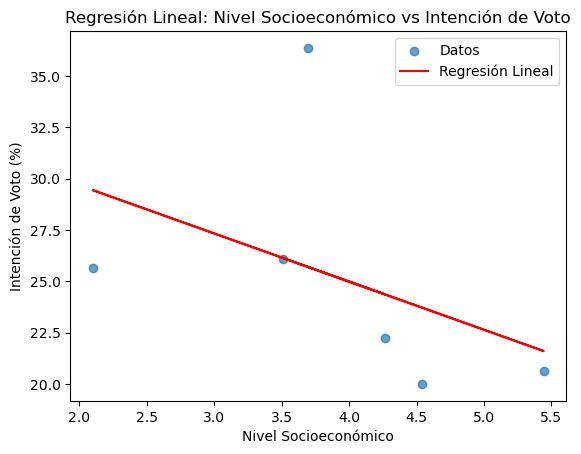

F:\Anaconda\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:        LIBERTARIOS_PCT   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                 -0.144
Method:                 Least Squares   F-statistic:                    0.3706
Date:                Tue, 26 Nov 2024   Prob (F-statistic):              0.576
Time:                        17:38:42   Log-Likelihood:                -14.461
No. Observations:                   6   AIC:                             32.92
Df Residuals:                       4   BIC:                             32.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

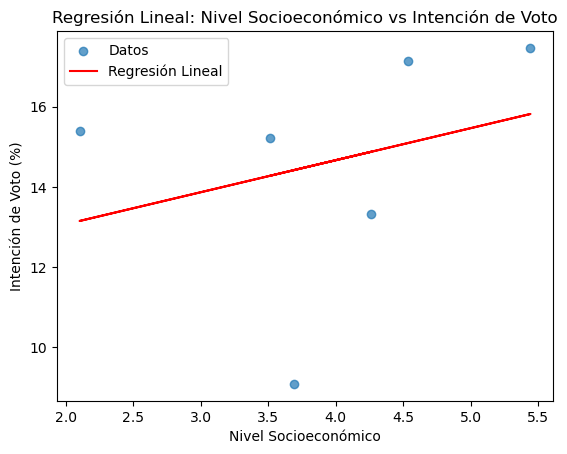

F:\Anaconda\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:                PNK_PCT   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     5.893
Date:                Tue, 26 Nov 2024   Prob (F-statistic):             0.0722
Time:                        17:38:42   Log-Likelihood:                -11.977
No. Observations:                   6   AIC:                             27.95
Df Residuals:                       4   BIC:                             27.54
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

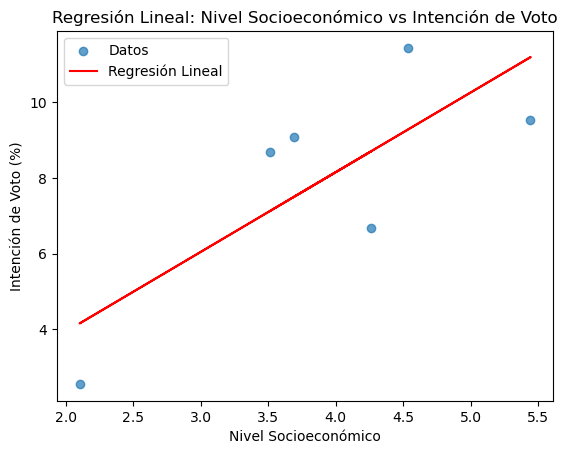

                            OLS Regression Results                            
Dep. Variable:                FIT_PCT   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     3.976
Date:                Tue, 26 Nov 2024   Prob (F-statistic):              0.117
Time:                        17:38:42   Log-Likelihood:                -11.607
No. Observations:                   6   AIC:                             27.21
Df Residuals:                       4   BIC:                             26.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

F:\Anaconda\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


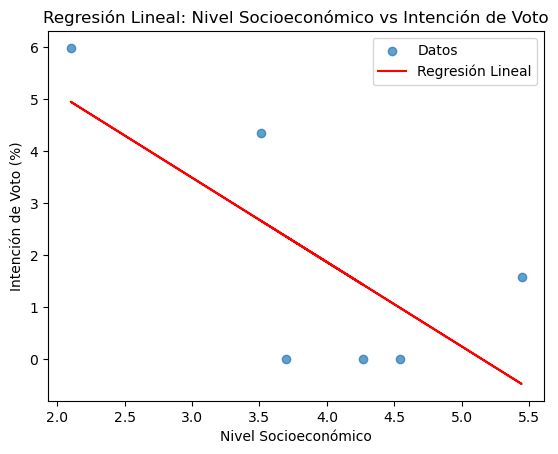

F:\Anaconda\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:              OTROS_PCT   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.247
Method:                 Least Squares   F-statistic:                  0.009665
Date:                Tue, 26 Nov 2024   Prob (F-statistic):              0.926
Time:                        17:38:43   Log-Likelihood:                -18.350
No. Observations:                   6   AIC:                             40.70
Df Residuals:                       4   BIC:                             40.28
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

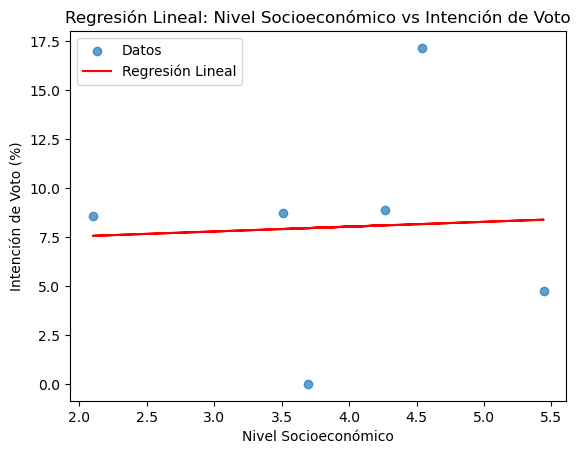

F:\Anaconda\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


                            OLS Regression Results                            
Dep. Variable:     NINGUNO/NOSABE_PCT   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.211
Method:                 Least Squares   F-statistic:                    0.1302
Date:                Tue, 26 Nov 2024   Prob (F-statistic):              0.736
Time:                        17:38:43   Log-Likelihood:                -19.322
No. Observations:                   6   AIC:                             42.64
Df Residuals:                       4   BIC:                             42.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const 

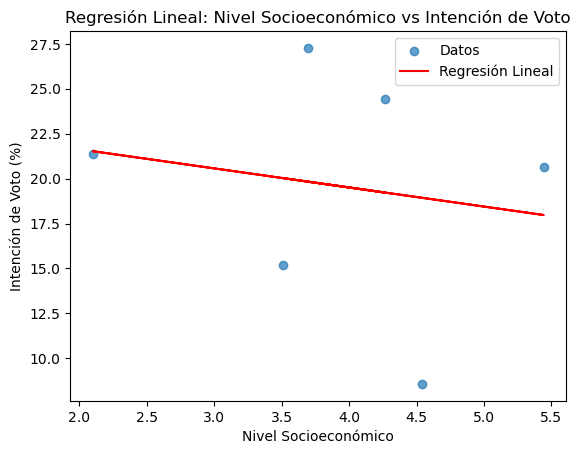

In [68]:
def regresion_nivel_socioeconomico_voto(partido_x):
    X = mapa_distritos['Segmento_socioeconomico_del_radio']
    X = sm.add_constant(X)
    y = mapa_distritos[partido_x]
    modelo = sm.OLS(y, X)
    resultados = modelo.fit()
    print(resultados.summary())
    mapa_distritos["predicciones"] = resultados.predict(X)

    # Mostrar gráfico
    plt.scatter(mapa_distritos["Segmento_socioeconomico_del_radio"], mapa_distritos[partido_x], label="Datos", alpha=0.7)
    plt.plot(mapa_distritos["Segmento_socioeconomico_del_radio"], mapa_distritos["predicciones"], color="red", label="Regresión Lineal")
    plt.xlabel("Nivel Socioeconómico")
    plt.ylabel("Intención de Voto (%)")
    plt.title("Regresión Lineal: Nivel Socioeconómico vs Intención de Voto")
    plt.legend()
    plt.show()

regresion_nivel_socioeconomico_voto('FdT_PCT')
regresion_nivel_socioeconomico_voto('JxC_PCT')
regresion_nivel_socioeconomico_voto('LIBERTARIOS_PCT')
regresion_nivel_socioeconomico_voto('PNK_PCT')
regresion_nivel_socioeconomico_voto('FIT_PCT')
regresion_nivel_socioeconomico_voto('OTROS_PCT')
regresion_nivel_socioeconomico_voto("NINGUNO/NOSABE_PCT")